In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import fcwt
%matplotlib inline

### Import and process KPLO Data

In [2]:
"Load KMAG Data"
kmag = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230116_GSE_1sec.csv', na_values='NaN')

"Convert KPLO Data to Numpy Arrays"
B1_x = kmag['MAG1-X'].to_numpy(); B1_y = kmag['MAG1-Y'].to_numpy(); B1_z = kmag['MAG1-Z'].to_numpy()
B2_x = kmag['MAG2-X'].to_numpy(); B2_y = kmag['MAG2-Y'].to_numpy(); B2_z = kmag['MAG2-Z'].to_numpy()
B3_x = kmag['MAG3-X'].to_numpy(); B3_y = kmag['MAG3-Y'].to_numpy(); B3_z = kmag['MAG3-Z'].to_numpy()
B_3b = np.vstack((B3_x, B3_y, B3_z));
B_2b = np.vstack((B2_x, B2_y, B2_z)); 
B_1b = np.vstack((B1_x, B1_y, B1_z)); 
B = np.array([B_1b, B_2b, B_3b])

"Extract Timestamps"
t = pd.to_datetime(kmag['UTC']).to_numpy()

In [3]:
"Load THEMIS Data"
themis = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230116_themis_thb_fgm_fgs_l2.csv')
Bx_th = themis['bx_gse'].to_numpy(); By_th = themis['by_gse'].to_numpy(); Bz_th = themis['bz_gse'].to_numpy()
B_th = np.array([Bx_th, By_th, Bz_th])
themis_t = pd.to_datetime(themis['UTC']).to_numpy()

array([1, 1, 1, ..., 1, 1, 1])

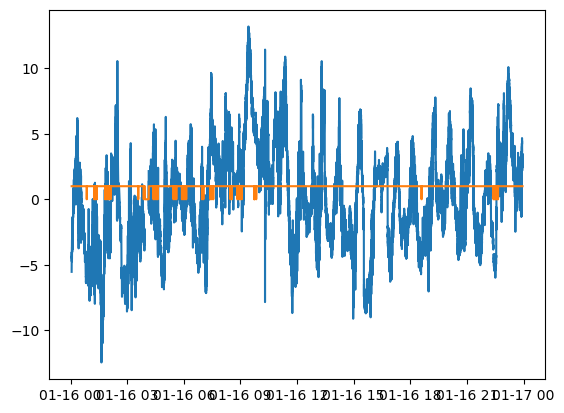

In [20]:

B = B[:,:,100:-100]; t = t[100:-100]
gaps = 1- np.isnan(B[0,0])
g = 1 - np.isnan(B[0,0])

plt.plot(t, B[0,0])
plt.plot(t, gaps)
gaps

### Interpolate the data


In [21]:
from magprime.utility import interpolation
interpolation.mssa.n_components = "parallel_analysis"
interpolation.mssa.pa_percentile_threshold = 5
interpolation.mssa.verbose = True
print(B.shape)
B_interpolated = interpolation.mssa.interpolate(B[:,2,:], gaps, triaxial=False)


(3, 3, 86000)


  0%|          | 0/44 [00:00<?, ?it/s]

Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 39%|███▊      | 17/44 [00:00<00:00, 80.25it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 3
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 59%|█████▉    | 26/44 [00:01<00:01, 11.35it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 68%|██████▊   | 30/44 [00:02<00:01,  9.09it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 75%|███████▌  | 33/44 [00:03<00:01,  8.10it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 3
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 80%|███████▉  | 35/44 [00:03<00:01,  7.80it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 11)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 1
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (33, 12)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (33, 12)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 84%|████████▍ | 37/44 [00:03<00:00,  7.45it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (111, 38)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 3
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (111, 38)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (168, 57)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 3
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (168, 57)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 89%|████████▊ | 39/44 [00:06<00:01,  3.06it/s]

Rank selected via parallel analysis: 5
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (168, 57)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 6
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (168, 57)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 91%|█████████ | 40/44 [00:07<00:01,  2.25it/s]

Rank selected via parallel analysis: 3
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (177, 60)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 4
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (177, 60)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 93%|█████████▎| 41/44 [00:08<00:01,  1.75it/s]

Rank selected via parallel analysis: 3
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (171, 58)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 4
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (171, 58)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

 98%|█████████▊| 43/44 [00:09<00:00,  1.68it/s]

Rank selected via parallel analysis: 4
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (2184, 729)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 7
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (2184, 729)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 44/44 [04:22<00:00,  5.96s/it]

Rank selected via parallel analysis: 14
Constructing components
Calculating optimal reconstruction orders


In [ ]:
"Calculate Coupling Coefficients"
from magprime.utility import calculate_coupling_coefficients


"Algorithm Parameters"
aii = calculate_coupling_coefficients(B_interpolated, fs = 1, sspTol=20)

1326


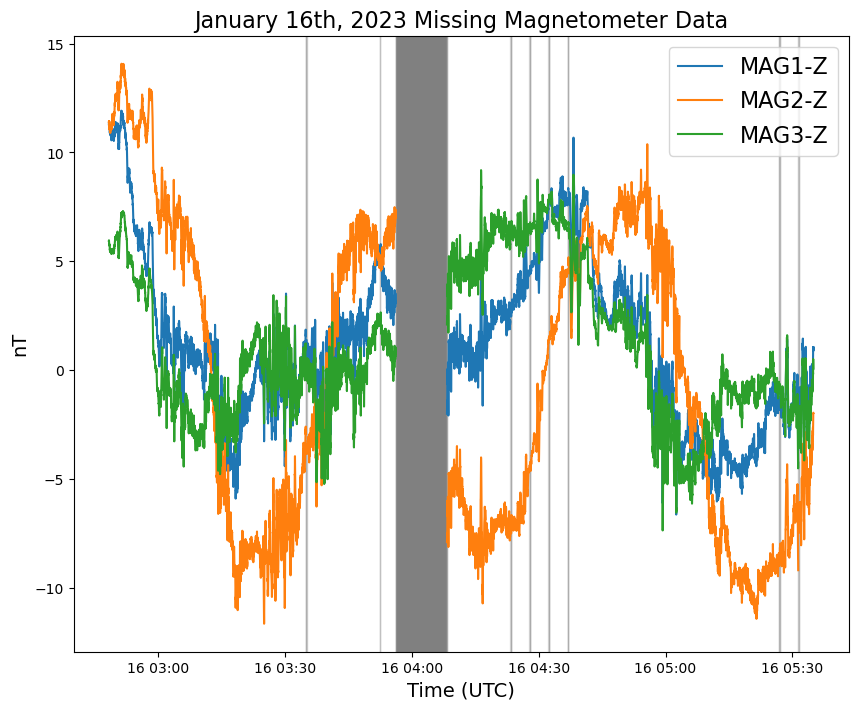

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True, sharey=True)
axs.set_title("January 16th, 2023 Missing Magnetometer Data", fontsize=16)
axs.plot(t[10000:20000], B[:,2,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])

plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("nT", fontsize=14)
plt.legend(loc=1, fontsize=16)

gap_indices = np.where(g[10000:20000] == 0)[0]

for idx in gap_indices:
    axs.axvspan(t[10000 + idx], t[10000 + idx + 1], color='grey', alpha=0.1)

print(np.sum(g == 0))

In [23]:

def find_gaps(gaps):
    # Find Gap starting and ending indices
    gap_indices = np.where(gaps == 0)[0]
    if gap_indices.size == 0:
        return []  # No gaps to fill

    gap_starts = np.hstack(([0], np.where(np.diff(gap_indices) != 1)[0] + 1))
    gap_ends = np.hstack((np.where(np.diff(gap_indices) != 1)[0], [len(gap_indices) - 1]))
    full_gaps = [(gap_indices[start], gap_indices[end]) for start, end in zip(gap_starts, gap_ends)]

    # Create a list to store gap info with window analysis
    gap_info = []

    for start, end in full_gaps:
        gap_length = end - start + 1
        window_radius = 2 * gap_length
        window_start = max(0, start - window_radius)
        window_end = min(len(gaps) - 1, end + window_radius)

        # Count valid data points in the window
        window_data_count = np.sum(gaps[window_start:start]) + np.sum(gaps[end + 1:window_end + 1])

        gap_info.append((start, end, gap_length, int(window_data_count//gap_length > 3)))

    # Rank gaps - example by smallest gap first, then by maximum surrounding data
    gap_info.sort(key=lambda x: (-x[3],x[2]))
    return(gap_info)

gap_info = find_gaps(g)
print(gap_info[-10:])

[(32266, 32275, 10, 1), (32536, 32545, 10, 1), (19512, 19522, 11, 1), (81391, 81427, 37, 1), (80746, 80801, 56, 1), (80962, 81017, 56, 1), (80523, 80581, 59, 1), (81171, 81180, 10, 0), (81182, 81238, 57, 0), (14070, 14797, 728, 0)]


### Plot Interpolated data

In [6]:
"Apply WAIC-UP"
from magprime.algorithms import WAICUP


"Note: WAIC-UP is not designed to work with low-frequency data due to the Cone of Influence (COI). Detrending is necessary to avoid low-frequency artefacts."
WAICUP.fs = 1 # Sampling Frequency
WAICUP.detrend = True # Detrend the data
WAICUP.uf = 8640*2 # Number of points in uniform filter (uf)
WAICUP.aii = np.array([ 7.01002316, 75.24653706,  6.26681301]) # Coupling Coefficients

"Clean the data"
B_WAICUP = WAICUP.clean(np.copy(B_interpolated), triaxial=True)

c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  waicup_level1[i] = dual(np.vstack((sig[pairs[i][0]], sig[pairs[i][1]])), dt, dj)
c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  result[axis] = cleanWAICUP(B[:,axis,:])


In [12]:

np.sum(np.isnan(B_interpolated[0,2]))


1326

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


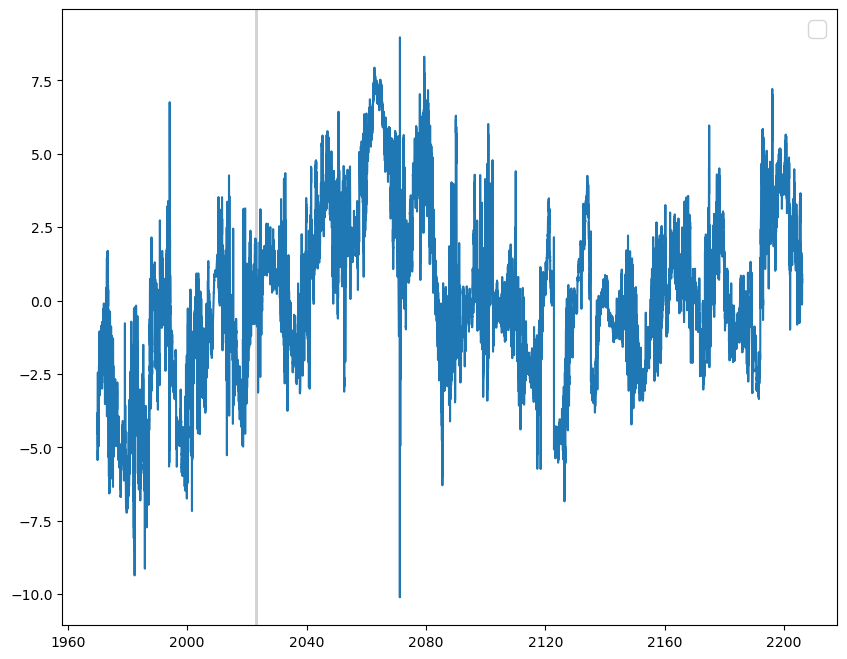

In [83]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
#th_start = 2276; th_end = 4603
for idx in gap_indices:
    axs.axvspan(t[10000 + idx], t[10000 + idx + 1], color='lightgrey', alpha=0.1)

#axs.plot(t[10000:20000], B_interpolated[:,2,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])
#axs.plot(t[10000:20000], B_WAICUP[2,10000:20000], label="WAIC-UP Z")
axs.plot(B_WAICUP.T)
#axs.plot(themis_t[th_start:th_end], B_th[2,th_start:th_end], label="THEMIS-Z")
axs.legend(loc=1, fontsize=16)

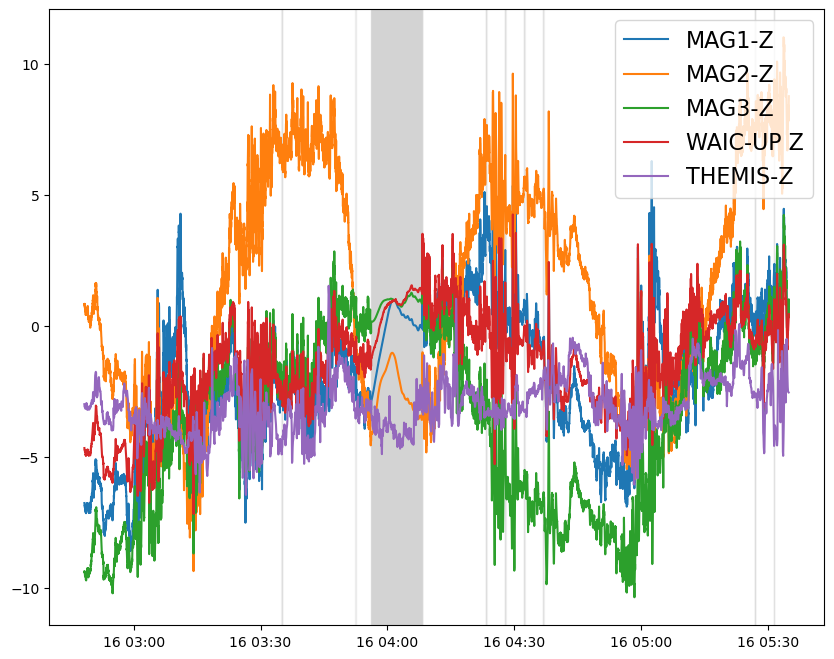

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
th_start = 2276; th_end = 4603
for idx in gap_indices:
    axs.axvspan(t[10000 + idx], t[10000 + idx + 1], color='lightgrey', alpha=0.1)

axs.plot(t[10000:20000], B_interpolated[:,0,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])
axs.plot(t[10000:20000], B_WAICUP[0,10000:20000], label="WAIC-UP Z")
axs.plot(themis_t[th_start:th_end], B_th[0,th_start:th_end], label="THEMIS-Z")
axs.legend(loc=1, fontsize=16)

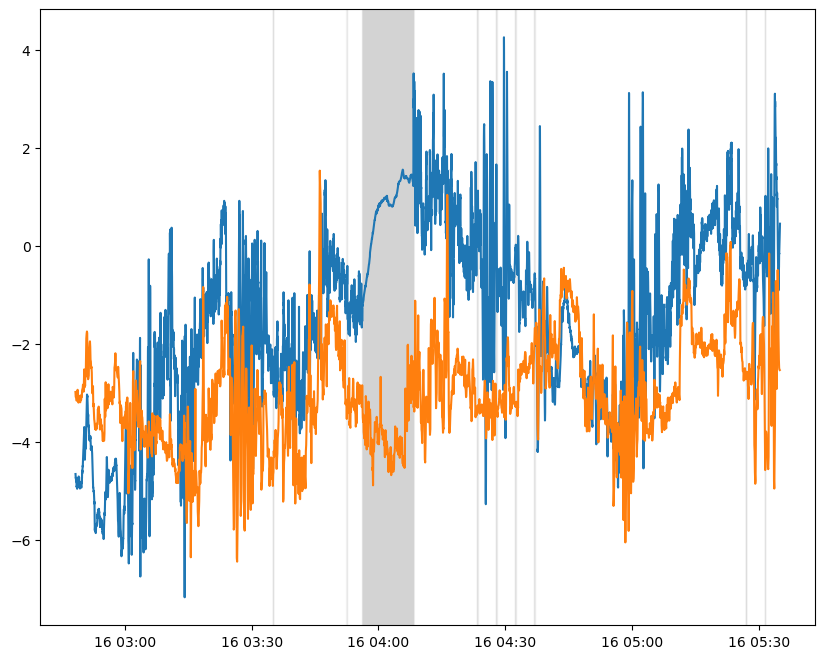

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
th_start = 2276; th_end = 4603
for idx in gap_indices:
    axs.axvspan(t[10000 + idx], t[10000 + idx + 1], color='lightgrey', alpha=0.1)

#axs.plot(t[10000:20000], B_interpolated[:,0,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])
axs.plot(t[10000:20000], B_WAICUP[0,10000:20000])
axs.plot(themis_t[th_start:th_end], B_th[0,th_start:th_end], label="THEMIS-Z")
